In [1]:
#pip install tensorflow

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
from tensorflow.keras import regularizers
from scipy.stats import ks_2samp

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
X = data.drop('Class', axis=1).values
y = data['Class'].values

In [5]:
pd.value_counts(data['Class'])

0    284315
1       492
Name: Class, dtype: int64

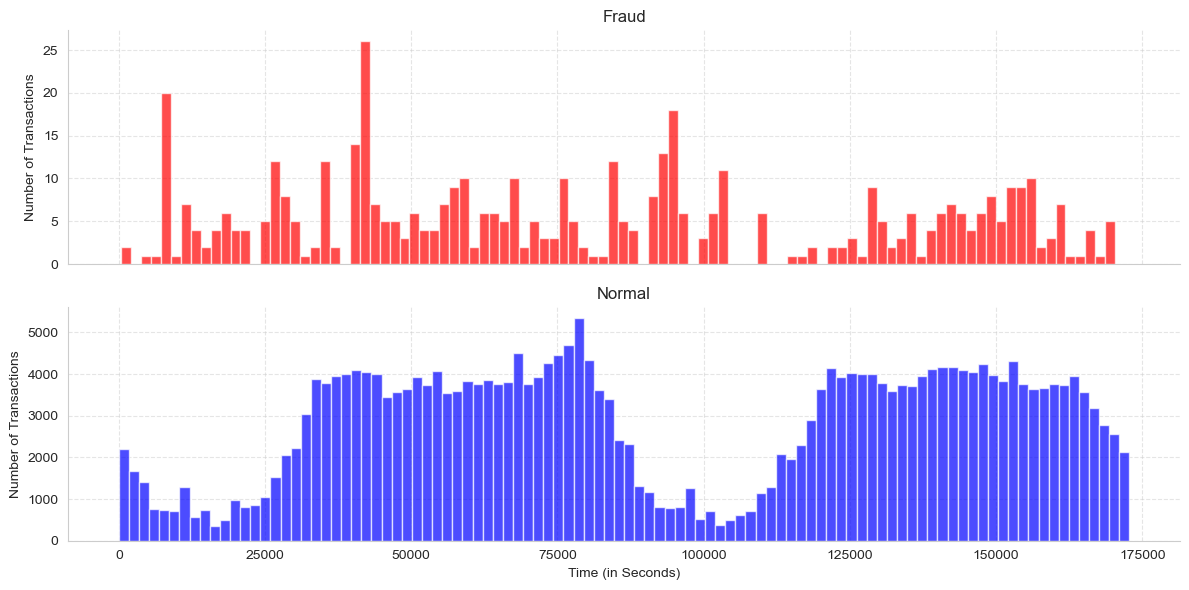

In [4]:
# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Set the number of bins
bins = 100

# Plot Fraud transactions
axes[0].hist(data.Time[data.Class == 1], bins=bins, color='red', alpha=0.7)
axes[0].set(title='Fraud', ylabel='Number of Transactions')
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot Normal transactions
axes[1].hist(data.Time[data.Class == 0], bins=bins, color='blue', alpha=0.7)
axes[1].set(title='Normal', xlabel='Time (in Seconds)', ylabel='Number of Transactions')
axes[1].grid(True, linestyle='--', alpha=0.5)

# Remove top and right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

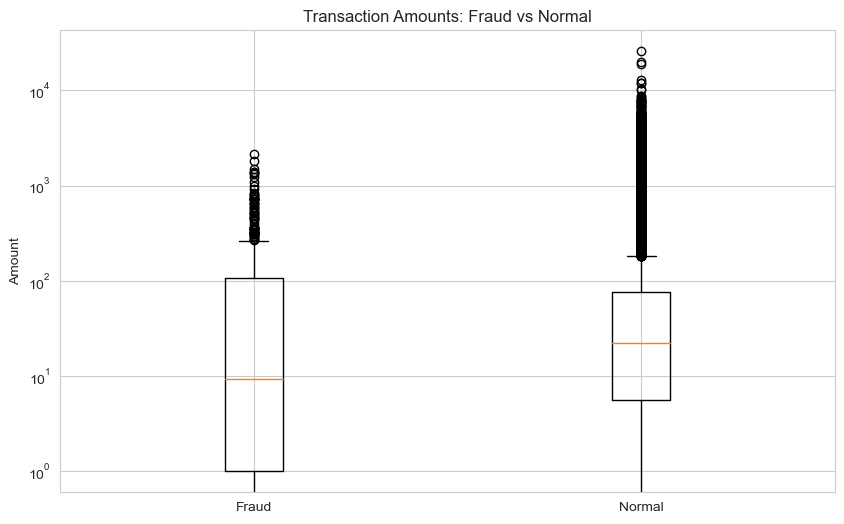

In [6]:
plt.figure(figsize=(10, 6))
plt.boxplot([data[data["Class"]==1]["Amount"], data[data["Class"]==0]["Amount"]], 
            labels=['Fraud', 'Normal'])

plt.title('Transaction Amounts: Fraud vs Normal')
plt.ylabel('Amount')
plt.yscale('log')
plt.show()

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=(X.shape[-1],),
                              kernel_regularizer=regularizers.l2(0.001)), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
metrics = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

In [10]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = metrics)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {0: 1, 1: 5}

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es], class_weight=class_weight)

Epoch 1/100

4006/4006 [==============================] - 7s 2ms/step - loss: 0.1736 - fn: 121.0000 - fp: 514.0000 - tn: 127428.0000 - tp: 100.0000 - precision: 0.1629 - recall: 0.4525 - val_loss: 0.0982 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 42633.0000 - val_tp: 60.0000 - val_precision: 0.8108 - val_recall: 0.8108
Epoch 2/100
4006/4006 [==============================] - 6s 1ms/step - loss: 0.0869 - fn: 51.0000 - fp: 26.0000 - tn: 127916.0000 - tp: 170.0000 - precision: 0.8673 - recall: 0.7692 - val_loss: 0.0605 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 42633.0000 - val_tp: 60.0000 - val_precision: 0.8108 - val_recall: 0.8108
Epoch 3/100
4006/4006 [==============================] - 6s 1ms/step - loss: 0.0584 - fn: 47.0000 - fp: 32.0000 - tn: 127910.0000 - tp: 174.0000 - precision: 0.8447 - recall: 0.7873 - val_loss: 0.0407 - val_fn: 11.0000 - val_fp: 16.0000 - val_tn: 42631.0000 - val_tp: 63.0000 - val_precision: 0.7975 - val_recall: 0.8514
Epoch 4/100
4006/4006 [===========

3561/3561 [==============================] - 3s 693us/step
Precision: 0.7596153846153846
Recall: 0.8020304568527918
F1 Score: 0.7802469135802468


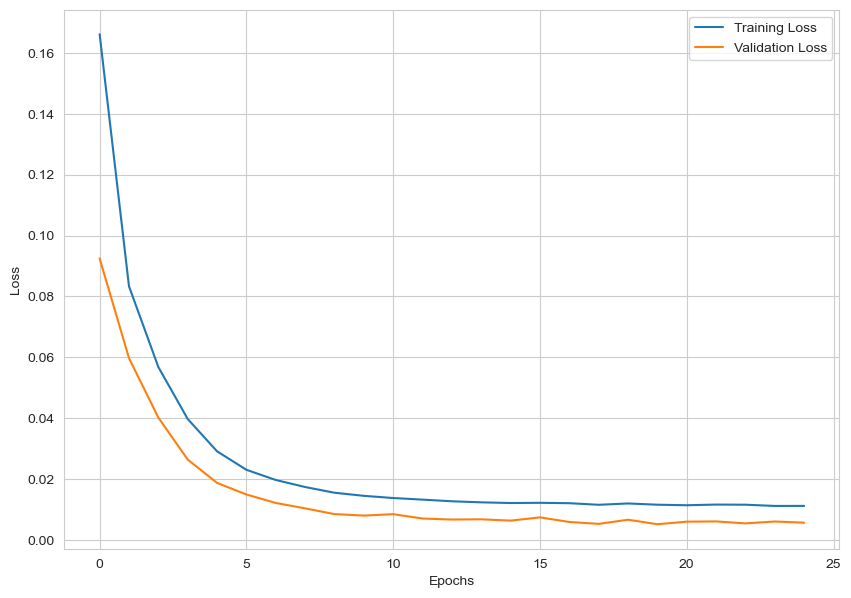

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()